# Problem description
The state variables are        $
x = \begin{bmatrix}x\\ y\\ \phi \end{bmatrix}
$ $\quad$
$
u = \begin{bmatrix}v_x\\ \omega \end{bmatrix}
$

$$
\dot{x} = \begin{bmatrix}v_x\cos\phi \\ v_x\sin\phi \\ \omega \end{bmatrix}
$$

There's a desired point to be at $(x_r,y_r)$

We define:
- $e_x=(x-x_r)$
- $e_y=(y-y_r)$

we want to minimize:
$$
e_x^2+e_y^2
$$

In [79]:
# Import necessary libraries
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import FancyArrow

# Dynamics and integration

In [80]:
# Dynamics definition

x = ca.MX.sym('x') # type: ignore
y = ca.MX.sym('y') # type: ignore
phi = ca.MX.sym('phi') # type: ignore
v_x = ca.MX.sym('v_x') # type: ignore
omega = ca.MX.sym('omega') # type: ignore

state = ca.vertcat(x, y, phi)
control = ca.vertcat(v_x, omega)

ode = ca.vertcat(
    v_x * ca.cos(phi),  # x_dot
    v_x * ca.sin(phi),  # y_dot  
    omega               # phi_dot
)

# Dynamics defined
f = ca.Function('f', [state, control], [ode], ['x', 'u'], ['ode'])

f

Function(f:(x[3],u[2])->(ode[3]) MXFunction)

## Use RK4 To discretize the system dynamics

In [81]:
N = 10  # Prediction horizon (number of time steps)
T = 0.1  # Sampling time
# Integrator options
intg_options = {
    'simplify': True,
    'number_of_finite_elements': 4
}

dae = {
    'x': state,      # What are states?
    'p': control,      # What are parameters (fixed during integration horizon)?
    'ode': f(state, control)   # Expression for the right-hand side
}
# integrator(str name, str solver, Function dae, float t0, [float] tout, dict opts) -> Function
intg = ca.integrator('intg', 'rk', dae, 0, N*T, intg_options)
x_next = intg(x0=state, p=control)['xf']

# Big F, the discretized function
F = ca.Function('F', [state, control], [x_next], ['x', 'u'], ['x_next'])
F

Function(F:(x[3],u[2])->(x_next[3]) MXFunction)

In [82]:
sim = F.mapaccum(N)
sim

Function(F_acc10:(x[3],u[2x10])->(x_next[3x10]) MXFunction)

In [83]:
# Symbolic u

U = ca.MX.sym('U', 2, N) # type: ignore
U

MX(U)

# Solve for problem

In [84]:
x_ref, y_ref = 10, 10

In [85]:
opti = ca.Opti()

x = opti.variable(3, N+1) # type: ignore
u = opti.variable(2, N) # type: ignore
p = opti.parameter(3, 1) # type: ignore

opti.minimize(ca.sumsqr(x-ca.vertcat(x_ref, y_ref, 0)))

for k in range(N):
    opti.subject_to(x[:, k+1] == F(x[:, k], u[:, k]))

# opti.solver('sqpmethod',{'qpsol':'osqp'})

opti.subject_to(x[:,0] == p)

# Set speed limit
opti.subject_to(u[0, :] <= 1)
opti.subject_to(u[0, :] >= 0)
opti.subject_to(u[1, :] <= 1)
opti.subject_to(u[1, :] >= -1)
# Set initial condition
opti.subject_to(x[:,0] == p)

opti.solver('ipopt')
opti.set_value(p, ca.vertcat(0, 0, 0))
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      136
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:       73

Total number of variables............................:       53
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       36
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:       20
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2000000e+03 0.00e+00 2.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

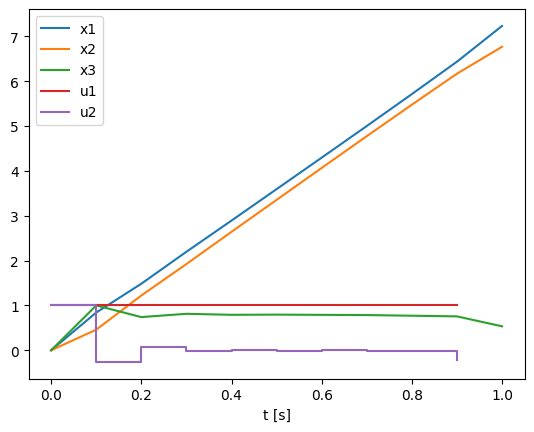

In [86]:
# Extract values from CasADi solution
x_vals = sol.value(x)  # Shape: (3, N) for 3 states
u_vals = sol.value(u)  # Shape: (2, N) for 2 inputs

tgrid = np.linspace(0, T*N, N+1)
plt.figure()
# Plot 3 states
plt.plot(tgrid, x_vals[0, :], label='x')
plt.plot(tgrid, x_vals[1, :], label='y') 
plt.plot(tgrid, x_vals[2, :], label='theta')

# Plot 2 inputs as steps
plt.step(tgrid[:-1], u_vals[0, :], where='post', label='u1')
plt.step(tgrid[:-1], u_vals[1, :], where='post', label='u2')

plt.xlabel('t [s]')
plt.legend(['x1', 'x2', 'x3', 'u1', 'u2'])

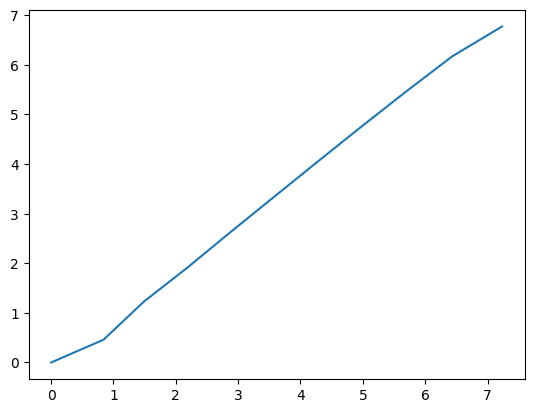

In [87]:
plt.figure()
plt.plot(x_vals[0, :], x_vals[1, :], label='pos')

In [88]:
M = opti.to_function('M',[p],[u[:,0]],['p'],['u_opt'])
M

Function(M:(p[3])->(u_opt[2]) MXFunction)

## MPC Loop

In [89]:
x_log = []
u_log = []

x = ca.vertcat(0, 0, 0)


for i in range(100):
    u = M(x)
    x_log.append(x)
    u_log.append(u)
    x = F(x, u)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      136
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:       73

Total number of variables............................:       53
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       36
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:       20
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2000000e+03 0.00e+00 2.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

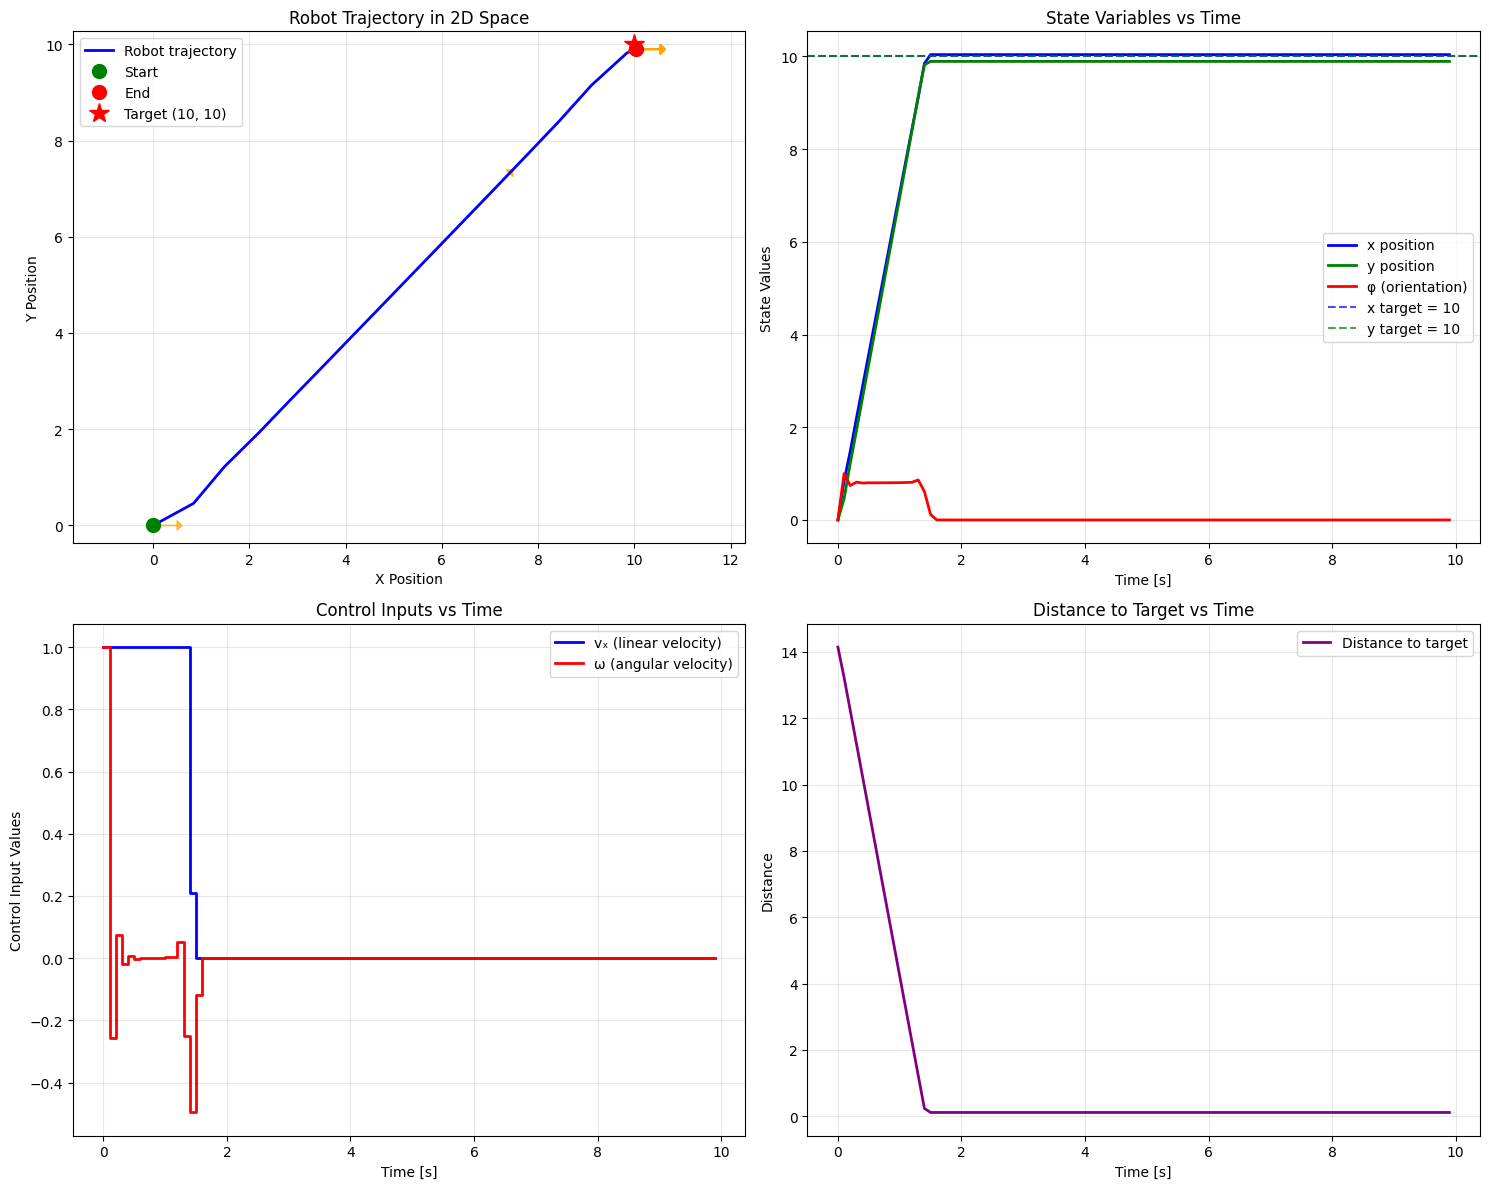

Simulation completed:
- Duration: 9.9 seconds
- Final position: (10.04, 9.89)
- Target position: (10, 10)
- Final distance to target: 0.114
- Final orientation: -0.000 rad (-0.0°)


In [90]:
# Convert CasADi arrays to numpy for plotting
x_traj = np.array([np.array(x).flatten() for x in x_log])  # Shape: (N, 3)
u_traj = np.array([np.array(u).flatten() for u in u_log])  # Shape: (N, 2)

# Time vector
time_steps = np.arange(len(x_log)) * T

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Trajectory in 2D space
ax1.plot(x_traj[:, 0], x_traj[:, 1], 'b-', linewidth=2, label='Robot trajectory')
ax1.plot(x_traj[0, 0], x_traj[0, 1], 'go', markersize=10, label='Start')
ax1.plot(x_traj[-1, 0], x_traj[-1, 1], 'ro', markersize=10, label='End')
ax1.plot(x_ref, y_ref, 'r*', markersize=15, label=f'Target ({x_ref}, {y_ref})')

# Add orientation arrows at regular intervals
arrow_interval = max(1, len(x_traj) // 10)
for i in range(0, len(x_traj), arrow_interval):
    x, y, phi = x_traj[i]
    dx = 0.5 * np.cos(phi)
    dy = 0.5 * np.sin(phi)
    ax1.arrow(x, y, dx, dy, head_width=0.2, head_length=0.1, 
              fc='orange', ec='orange', alpha=0.7)

ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.set_title('Robot Trajectory in 2D Space')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.axis('equal')

# 2. State variables over time
ax2.plot(time_steps, x_traj[:, 0], 'b-', linewidth=2, label='x position')
ax2.plot(time_steps, x_traj[:, 1], 'g-', linewidth=2, label='y position')
ax2.plot(time_steps, x_traj[:, 2], 'r-', linewidth=2, label='φ (orientation)')
ax2.axhline(y=x_ref, color='b', linestyle='--', alpha=0.7, label=f'x target = {x_ref}')
ax2.axhline(y=y_ref, color='g', linestyle='--', alpha=0.7, label=f'y target = {y_ref}')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('State Values')
ax2.set_title('State Variables vs Time')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Control inputs over time
ax3.step(time_steps, u_traj[:, 0], 'b-', linewidth=2, where='post', label='vₓ (linear velocity)')
ax3.step(time_steps, u_traj[:, 1], 'r-', linewidth=2, where='post', label='ω (angular velocity)')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Control Input Values')
ax3.set_title('Control Inputs vs Time')
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. Distance to target over time
distances = np.sqrt((x_traj[:, 0] - x_ref)**2 + (x_traj[:, 1] - y_ref)**2)
ax4.plot(time_steps, distances, 'purple', linewidth=2, label='Distance to target')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Distance')
ax4.set_title('Distance to Target vs Time')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Simulation completed:")
print(f"- Duration: {time_steps[-1]:.1f} seconds")
print(f"- Final position: ({x_traj[-1, 0]:.2f}, {x_traj[-1, 1]:.2f})")
print(f"- Target position: ({x_ref}, {y_ref})")
print(f"- Final distance to target: {distances[-1]:.3f}")
print(f"- Final orientation: {x_traj[-1, 2]:.3f} rad ({np.degrees(x_traj[-1, 2]):.1f}°)")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Creating animation frames...


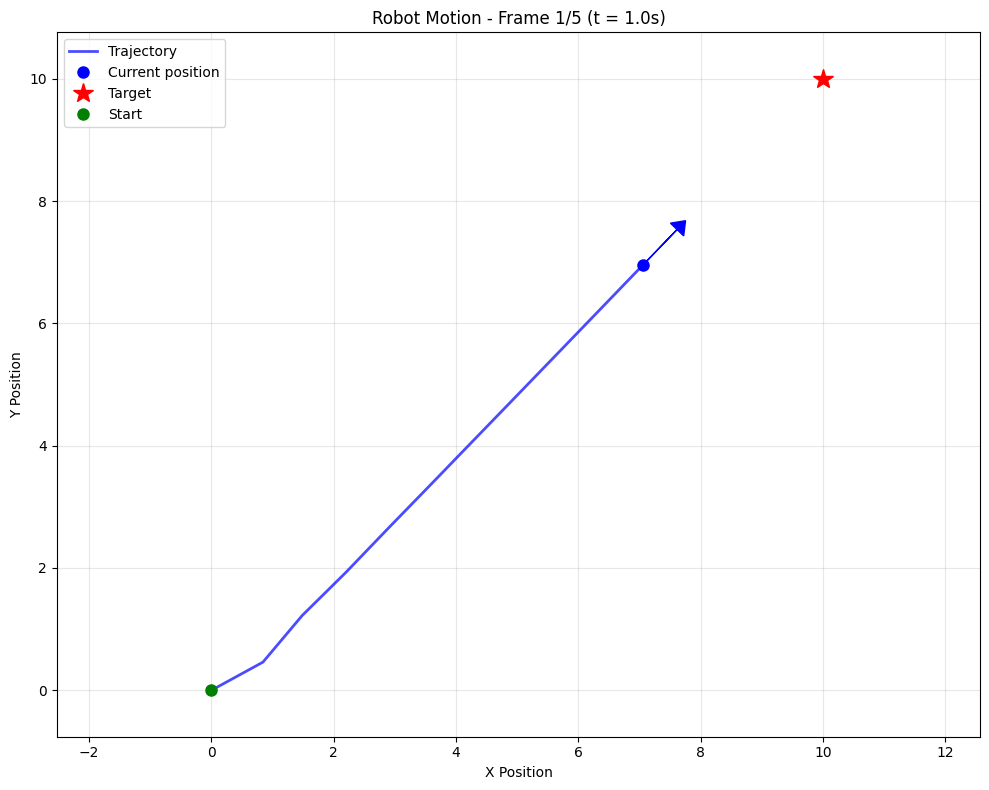

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Visualization complete!


In [91]:
# Create an animated version (static frames)
print("Creating animation frames...")
fig_anim, ax_anim = plt.subplots(figsize=(10, 8))

# Show trajectory evolution in steps
n_frames = 5
frame_indices = np.linspace(10, len(x_traj)-1, n_frames, dtype=int)

for i, frame_idx in enumerate(frame_indices):
    ax_anim.clear()
    
    # Plot trajectory up to current frame
    ax_anim.plot(x_traj[:frame_idx+1, 0], x_traj[:frame_idx+1, 1], 'b-', 
                linewidth=2, alpha=0.7, label='Trajectory')
    
    # Current position
    current_x, current_y, current_phi = x_traj[frame_idx]
    ax_anim.plot(current_x, current_y, 'bo', markersize=8, label='Current position')
    
    # Orientation arrow
    dx = 0.8 * np.cos(current_phi)
    dy = 0.8 * np.sin(current_phi)
    ax_anim.arrow(current_x, current_y, dx, dy, head_width=0.3, head_length=0.2, 
                 fc='blue', ec='blue')
    
    # Target
    ax_anim.plot(x_ref, y_ref, 'r*', markersize=15, label='Target')
    
    # Start point
    ax_anim.plot(x_traj[0, 0], x_traj[0, 1], 'go', markersize=8, label='Start')
    
    ax_anim.set_xlabel('X Position')
    ax_anim.set_ylabel('Y Position')
    ax_anim.set_title(f'Robot Motion - Frame {i+1}/{n_frames} (t = {time_steps[frame_idx]:.1f}s)')
    ax_anim.grid(True, alpha=0.3)
    ax_anim.legend()
    ax_anim.axis('equal')
    
    # Set consistent axis limits
    margin = 1.0
    x_min, x_max = min(0, x_ref) - margin, max(x_traj[-1, 0], x_ref) + margin
    y_min, y_max = min(0, y_ref) - margin, max(x_traj[-1, 1], y_ref) + margin
    ax_anim.set_xlim(x_min, x_max)
    ax_anim.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()

print("Visualization complete!")